In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
admissions_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/ADMISSIONS.csv")
icustays_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/ICUSTAYS.csv")
noteevents_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/NOTEEVENTS.csv", dtype={'TEXT': str})
patients_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/PATIENTS.csv")

<ipython-input-7-b758265df432>:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/NOTEEVENTS.csv", dtype={'TEXT': str})


In [ ]:
admissions_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/ADMISSIONS.csv")
icustays_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/ICUSTAYS.csv")
noteevents_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/NOTEEVENTS.csv", dtype={'TEXT': str})
patients_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/PATIENTS.csv")

<ipython-input-3-b758265df432>:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv("/content/drive/MyDrive/Classes/Stats 140XP/NOTEEVENTS.csv", dtype={'TEXT': str})


In [ ]:
# LOS column = length of stay
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [ ]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
noteevents_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [ ]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [ ]:
noteevents_df["CATEGORY"].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [ ]:
# Filter to discharge summaries only
discharge_summaries = noteevents_df[noteevents_df["CATEGORY"] == "Discharge summary"]

# For patients that appear in the ICU stays table, merge on (SUBJECT_ID, HADM_ID)
# Note: HADM is hospital admission id
icustays_with_notes = pd.merge(
    icustays_df,
    discharge_summaries,
    on=["SUBJECT_ID", "HADM_ID"],
    how="inner"
)

columns_to_keep = ["SUBJECT_ID","HADM_ID","ICUSTAY_ID","FIRST_CAREUNIT","LAST_CAREUNIT","FIRST_WARDID","LAST_WARDID",
                   "INTIME","OUTTIME","CHARTDATE","CATEGORY","TEXT","LOS"]

icustays_with_notes = icustays_with_notes[columns_to_keep]

# I checked the len of unique subject ids and hospital admission ids vs len of dataframe and they differ, so
# there likely are multiple discharge summaries per icu stay or multiple icu stays per hospital admission or
# multiple hospital admissions per subject etc but I think it doesnt really matter if we treat each as seperate
# entry? Or do we want to aggregate them? What do you guys think?

count    63204.000000
mean         5.844876
std         11.314764
min          0.000100
25%          1.290500
50%          2.389800
75%          5.192400
max        173.072500
Name: LOS, dtype: float64


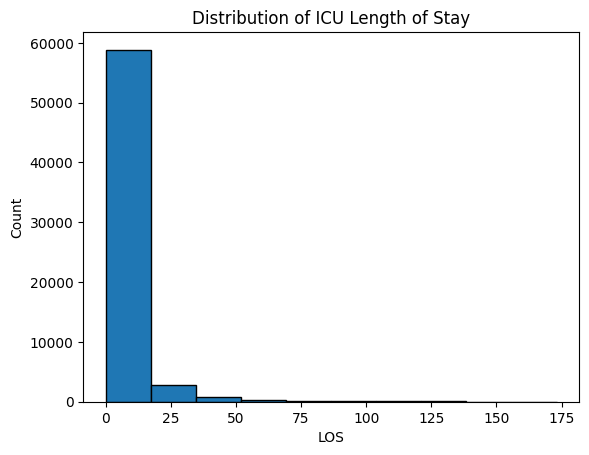

In [ ]:
# Checking distribution of LOS
print(icustays_with_notes["LOS"].describe())

plt.hist(icustays_with_notes["LOS"], bins=10, edgecolor='k')
plt.title("Distribution of ICU Length of Stay")
plt.xlabel("LOS")
plt.ylabel("Count")
plt.show()

In [ ]:
# Create interactive histogram with Plotly Express
fig = px.histogram(icustays_with_notes, x="LOS", nbins=30,
                     title="Distribution of ICU Length of Stay",
                     labels={"LOS": "Length of Stay (Days)", "count": "Count"})
fig.update_layout(bargroupgap=0.1)

# Show the plot
fig.show()

In [ ]:
# Filtering out invalid LOS
icustays_with_notes = icustays_with_notes[
    (icustays_with_notes["LOS"] > 0) &
    (icustays_with_notes["LOS"] < 365)  # Not sure what treshold for unrealistically long stay should be used
]

In [ ]:
def preprocess_text(text):
    # Removes "masked" [**...**] patterns
    text = re.sub(r"\[\*\*.*?\*\*\]", "", text)
    # Lowercase
    text = text.lower()
    # Removes line breaks
    text = text.replace("\n", " ")
    # Removes punctuation (do we want this or is this part of emotions in the text?)
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

icustays_with_notes["clean_text"] = icustays_with_notes["TEXT"].apply(preprocess_text)

In [ ]:
# There are +60k rows so maybe we only keep first 10k otherwise will take ages?
y = icustays_with_notes["LOS"].iloc[0:10000].values

# We can combine w numeric features if we want
X = icustays_with_notes["clean_text"].iloc[0:10000]

### Random Forest (using TF-IDF features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=37
)

In [ ]:
# One approach using TF-IDF to create features, and Random Forest to predict
# NOTE: this is not doing sentiment analysis yet, it just uses frequency of 1 word or 2 consecutive words in the notes to predict LOS, more abt
# TF-IDF explained below

# max_features limits vocab to max 5,000 tokens - tbh idk what should be used but I'm assuming larger = slower
# but more accurate too?
# ngram_range=(1,2) includes single words and pairs of consecutive words
# stop_words="english" filters out common "stop words" like "the", "and" etc but we can also put our own list
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=37))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {round(rmse, 4)}")
print(f"R^2: {round(r2, 4)}")

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

The approach above uses: TF-IDF = Term Frequency–Inverse Document Frequency
- Converts a collection of documents into numeric feature matrix that a machine-learning model can process
- Say N documents, vocabulary of M unique words (or tokens) that appear across all documents, you end up with an N×M matrix where each row corresponds to a document, and each column corresponds to a word/token, the value in cell (i, j) represents how important word j is in document i under the TF-IDF scheme
- Term Frequency measures how often a token (word) appears in a single document
- Inverse Document Frequency captures how “rare” a term is across all documents
- If a word is high frequency in a particular document but rare across whole docs, it’ll have a high TF-IDF value for that document
- A word that’s frequent in many documents will have a low TF-IDF

In [ ]:
# Here we use the same approach but we try a log transformation on LOS bc its distribution is a bit skewed (showed in histogram above)
# so this may improve performance

icustays_with_notes["LOS_log"] = np.log1p(icustays_with_notes["LOS"])

y_log = icustays_with_notes["LOS_log"].iloc[0:10000].values             # log-transformed LOS

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.3, random_state=37
)

pipeline_log = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words="english")),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=37))
])

pipeline_log.fit(X_train, y_train_log)

# Predicting in log space, then exponentiating to convert back to original scale
y_pred_log = pipeline_log.predict(X_test)

# (inverse of log1p is expm1)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"RMSE (original LOS scale): {round(rmse,4)}")
print(f"R^2 (original LOS scale): {round(r2,4)}")

RMSE (original LOS scale): 9.5086
R^2 (original LOS scale): 0.5017


### LASSO (using TF-IDF features)

In [ ]:
# Applying LASSO regularization to see if doing feature selection (use only best word tokens) improves performance
# We tune alpha with grid search cross validation

pipeline_lasso = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, stop_words="english", ngram_range=(1,2))),
    ("lasso", Lasso(random_state=37))
])

param_grid = {
    "lasso__alpha": [0.001, 0.01, 0.1, 1, 5]
}

search = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',   # or 'r2'
    cv=5,                               # 5-fold cv
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV score (MSE):", search.best_score_)

best_lasso_model = search.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso RMSE: {round(rmse_lasso,4)}")
print(f"Lasso R^2: {round(r2_lasso,4)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 998.5606774011976, tolerance: 141.46167817077065
  model = cd_fast.sparse_enet_coordinate_descent(


Best params: {'lasso__alpha': 0.001}
Best CV score (MSE): -93.68361673966182
Lasso RMSE: 8.8482
Lasso R^2: 0.5685


With LASSO: RMSE: 8.8482 R^2: 0.5685

### Neural Network (TF_IDF features)

In [ ]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("nn", MLPRegressor(hidden_layer_sizes=(100,), random_state=37, max_iter=500))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Neural Network RMSE: {round(rmse, 4)}")
print(f"Neural Network R^2: {round(r2, 4)}")


Neural Network RMSE: 8.86
Neural Network R^2: 0.5674


### Sentiment Analysis

In [ ]:
!pip install textblob

In [ ]:
# Trying sentiment analysis by giving text a sentiment score ranging from more negative to more positive
# IDK how well clinical text will map to sentiments
# Below is a library that offers an unsupervised approach but ngl i've never tried using it before

from textblob import TextBlob

def get_sentiment_score(text):
    # Returns in range [-1.0, 1.0]
    return TextBlob(text).sentiment.polarity

icustays_with_notes["sentiment_score"] = icustays_with_notes["clean_text"].iloc[:5000].apply(get_sentiment_score)

# After this we can either classify the score and apply classification, or keep as is and do regression?

X_text = icustays_with_notes["clean_text"].iloc[:5000].values
y_sent = icustays_with_notes["sentiment_score"].iloc[:5000].values  # Target = continuous sentiment

X_train_raw, X_test_raw, y_train_sent, y_test_sent = train_test_split(
    X_text,
    y_sent,
    test_size=0.3,
    random_state=37
)

sentiment_reg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("rf_reg", RandomForestRegressor(n_estimators=100, random_state=37))
])

sentiment_reg_pipeline.fit(X_train_raw, y_train_sent)

y_pred_sent = sentiment_reg_pipeline.predict(X_test_raw)

mse = mean_squared_error(y_test_sent, y_pred_sent)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_sent, y_pred_sent)

print(f"Regression on Sentiment - RMSE: {round(rmse, 4)}")
print(f"Regression on Sentiment - R^2: {round(r2,4)}")

Regression on Sentiment - RMSE: 0.0423
Regression on Sentiment - R^2: 0.3236


Regression on Sentiment - RMSE: 0.0423
Regression on Sentiment - R^2: 0.3236 (note we only used first 5k rows instead of 10k for sentiment bc was taking forever)

# BioBERT implementation

In [ ]:
icustays_with_notes = pd.merge(icustays_df, noteevents_df[['HADM_ID', 'TEXT']], on='HADM_ID', how='inner')

In [ ]:
def clean_text(text):
    text = str(text) #convert to string to handle nan values
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [ ]:
noteevents_df_subset = icustays_with_notes.iloc[:10000,] #reads only the subset of lines

In [ ]:
noteevents_df_subset['clean_text'] = noteevents_df_subset['TEXT'].apply(clean_text)

<ipython-input-15-be02a9548869>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noteevents_df_subset['clean_text'] = noteevents_df_subset['TEXT'].apply(clean_text)


In [ ]:
noteevents_df_subset['clean_text'].unique()

array(['admission date       discharge date  date of birth        sex  fservicehistory of present illness   this is a  year old femalewith a past medical history notable for diabetes mellitushypertension coronary artery disease status post myocardialinfarction and coronary artery bypass graft right lowerlobectomy asthma and congestive heart failure who presentscomplaining of cough times one week malaise and fatiguethe patient had a low grade temperature of  f at homethe patient denied any lower extremity edema or weight gainthe patients peak flows at home were in the  rangethe patient was recently admitted to the hospital until  for similar complaints of shortness ofbreath and cough  at that time she was treated withsteroids azithromycin and nebulizers for a presumedbronchitis exacerbationin the emergency room the patient was treated with acombivent nebulizer solumedrol intravenously levaquin andlasixpast medical   diabetes mellitus type       coronary artery disease status post inferi

In [ ]:
noteevents_df_subset.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,TEXT,clean_text
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249,Admission Date: [**2198-2-11**] Discharge...,admission date discharge date date of b...
1,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249,Sinus tachycardia\nProbable old inferior infar...,sinus tachycardiaprobable old inferior infarct...
2,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249,Probable atrial fibrillation with uncontrolled...,probable atrial fibrillation with uncontrolled...
3,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249,"Sinus rhythm. Inferior myocardial infarction, ...",sinus rhythm inferior myocardial infarction ag...
4,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.249,Sinus rhythm. Significant Q waves in the infer...,sinus rhythm significant q waves in the inferi...


In [ ]:
# Setup GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU is available
Device name: Tesla T4


In [ ]:
# Load BioBERT Model and Tokenizer
biobert_model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(biobert_model_name)
model = AutoModel.from_pretrained(biobert_model_name)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def biobert_embedding(text):
    # Tokenize the text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    # Get the model's output
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Extract the embeddings (usually the mean of the last hidden layer)
    embeddings = model_output.last_hidden_state.mean(dim=1).cpu().numpy()  # Move to CPU for sklearn

    return embeddings


In [ ]:
batch_size = 32  # Adjust based on your GPU memory
embeddings = []

for i in tqdm(range(0, len(noteevents_df_subset), batch_size)):
    batch_texts = noteevents_df_subset['clean_text'][i:i+batch_size].tolist()
    batch_embeddings = biobert_embedding(batch_texts)
    embeddings.append(batch_embeddings)

X = np.concatenate(embeddings, axis=0)
print(X.shape)


100%|██████████| 313/313 [04:29<00:00,  1.16it/s]

(10000, 768)


In [ ]:
# Assuming you have a target variable 'y' (e.g., ICU LOS)
y = noteevents_df_subset['LOS']

# Split the data into training and testing sets
# X is our embeddings and y is duration of icu_stay
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest (using BioBert features)

In [ ]:
# Assuming you have a target variable 'y' (e.g., ICU LOS)
y = noteevents_df_subset['LOS']

# Split the data into training and testing sets
# X is our embeddings and y is duration of icu_stay
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regression:")
print(f"  Root Mean Squared Error: {rmse}")
print(f"  R-squared: {r2}")

BERT RMSE: 22.159
BERT R^2: 0.5083


### Gradient Boosting (using BioBert features)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
gbr_predictions = gbr.predict(X_test)
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_rmse = np.sqrt(gbr_mse)
gbr_r2 = r2_score(y_test, gbr_predictions)

print("\nGradient Boosting Regression:")
print(f"  Root Mean Squared Error: {gbr_rmse}")
print(f"  R-squared: {gbr_r2}")


Gradient Boosting Regression:
  Root Mean Squared Error: 21.7870042332332
  R-squared: 0.5246344295098981



Gradient Boosting Regression:
  Root Mean Squared Error: 21.7870042332332
  R-squared: 0.5246344295098981

### Lasso (using BioBert features)

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("Lasso Regression:")
print(f"  Root Mean Squared Error: {lasso_rmse}")
print(f"  R-squared: {lasso_r2}")

Lasso Regression:
  Root Mean Squared Error: 22.90631584648702
  R-squared: 0.47453574577133717


Lasso Regression:
  Root Mean Squared Error: 22.90631584648702
  R-squared: 0.47453574577133717